## 01 Analisis exploratorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_transactions = pd.read_csv('../data/Transactions.csv', parse_dates=['Date'])
df_products = pd.read_csv('../data/Products.csv')

df_merge_txp = df_transactions.merge(df_products[['ProductID','UnitPrice', 'CostPrice', 'ProductName', 'Category']], on='ProductID', how='left')


In [3]:
df_merge_txp['TotalPrice'] = df_merge_txp['Quantity'] * df_merge_txp['UnitPrice']
df_merge_txp['TotalPriceWithDiscount'] = df_merge_txp['TotalPrice'] - (df_merge_txp['TotalPrice'] * df_merge_txp['Discount'])
df_merge_txp['TotalCost'] = df_merge_txp['Quantity'] * df_merge_txp['CostPrice']
df_merge_txp['Revenue'] = df_merge_txp['TotalPriceWithDiscount'] - df_merge_txp['TotalCost']
df_merge_txp['RevenuePerProduct'] = df_merge_txp['Revenue'] / df_merge_txp['Quantity']

In [4]:
df_merge_txp.head()

,TransactionID,Date,CustomerID,ProductID,StoreID,Quantity,Discount,PaymentMethod,UnitPrice,CostPrice,ProductName,Category,TotalPrice,TotalPriceWithDiscount,TotalCost,Revenue,RevenuePerProduct
0,T00001,2024-06-18,C160,P014,S003,1,0.10,Bank Transfer,1342.75,797.94,Add Clothing,Fashion,1342.75,1208.475,797.94,410.535,410.535
1,T00002,2023-11-02,C171,P030,S004,3,0.15,Bank Transfer,29.24,15.28,National Watches,Fashion,87.72,74.562,45.84,28.722,9.574
2,T00003,2024-03-28,C142,P002,S002,2,0.15,Mobile Money,818.76,527.62,Audience Television,Electronics,1637.52,1391.892,1055.24,336.652,168.326
3,T00004,2024-06-15,C174,P050,S002,5,0.10,Mobile Money,1044.64,775.07,Maybe Footwear,Fashion,5223.20,4700.880,3875.35,825.530,165.106
4,T00005,2024-08-29,C141,P036,S001,3,0.10,Credit Card,1501.46,1167.73,New Watches,Fashion,4504.38,4053.942,3503.19,550.752,183.584


#### Análisis por producto

In [5]:
prod_rank = df_merge_txp.groupby(["ProductID", "ProductName"]).agg(
    unit_sold=("Quantity", "sum"),
    revenue=("Revenue", "sum"),
    avg_price=("UnitPrice", "mean"),
).sort_values("unit_sold", ascending=False)
top10 = prod_rank.head(10)
last10 = prod_rank.tail(10)

##### Productos más y menos vendidos

In [6]:
print('10 Productos más vendidos')
print(top10)

10 Productos más vendidos
                               unit_sold      revenue  avg_price
ProductID ProductName                                           
P029      Road Clothing              346  137641.6375    1485.05
P022      How Vegetables             343    1699.3900      25.57
P002      Audience Television        341   78441.2980     818.76
P034      Everything Laptop          338   51214.6375     428.05
P037      Book Television            337  115950.6125    1952.65
P023      And Footwear               336  244603.2625    1878.47
P013      World Watches              335  123927.3000    1134.80
P048      Nor Bags                   332  110522.0080    1216.36
P045      Set Dairy                  330  242272.2780    1879.08
P021      Firm Dairy                 327   52774.8240    1227.24


In [7]:
print('10 Productos menos vendidos')
print(last10)

10 Productos menos vendidos
                                 unit_sold      revenue  avg_price
ProductID ProductName                                             
P004      Four Accessories             275   96260.3340    1853.77
P038      Stage Footwear               270   14371.8165     366.93
P018      Democratic Smartphone        268   76918.5110    1079.89
P047      Or Smartphone                268  104164.0640    1197.18
P043      Soon Accessories             256   56933.4040     564.42
P016      House Accessories            254   64401.1725    1858.75
P044      Least Accessories            250   97936.7050    1286.55
P007      Understand Camera            245  146334.7500    1474.12
P042      Maybe Clothing               245   24671.5980     453.62
P025      Little Watches               225   30815.1675     429.15


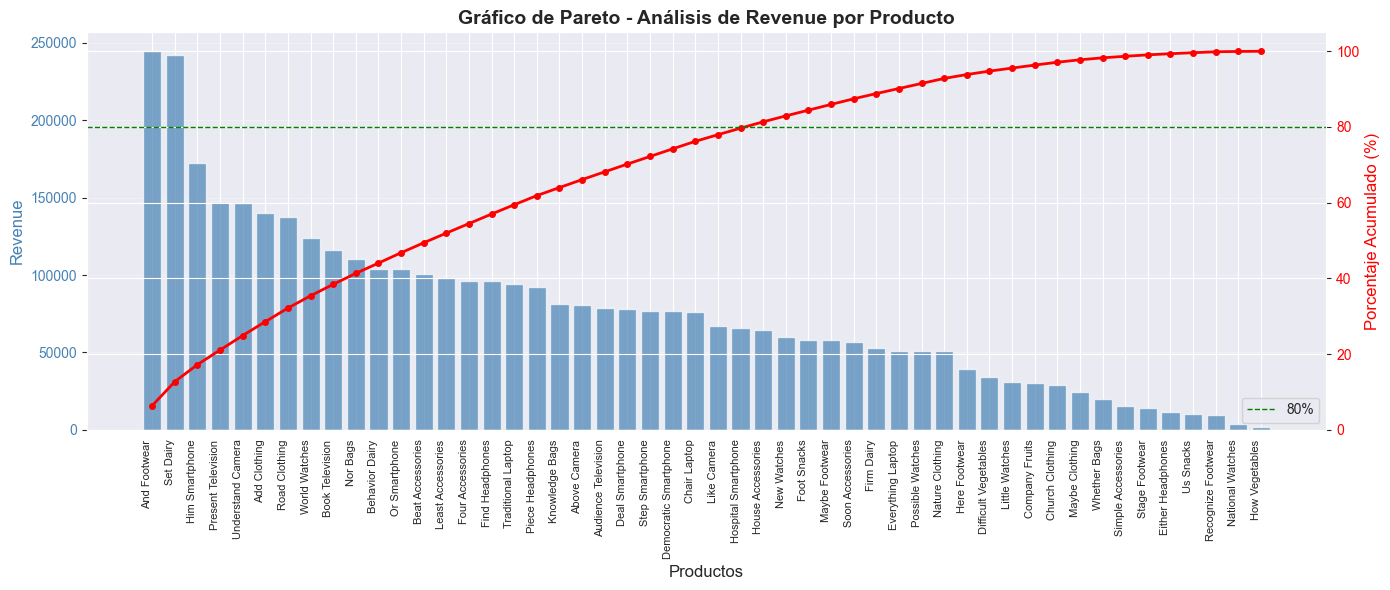

In [8]:
prod_rank_pareto = df_merge_txp.groupby(["ProductID", "ProductName"]).agg(
    unit_sold=("Quantity", "sum"),
    revenue=("Revenue", "sum"),
    avg_price=("UnitPrice", "mean"),
).sort_values("revenue", ascending=False)

prod_rank_reset = prod_rank_pareto.reset_index()

# Calcular el porcentaje del total y el porcentaje acumulado
prod_rank_reset['revenue_pct'] = (prod_rank_reset['revenue'] / prod_rank_reset['revenue'].sum()) * 100
prod_rank_reset['cumulative_pct'] = prod_rank_reset['revenue_pct'].cumsum()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Barras de revenue
x_pos = range(len(prod_rank_reset))
ax1.bar(x_pos, prod_rank_reset['revenue'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Productos', fontsize=12)
ax1.set_ylabel('Revenue', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(prod_rank_reset['ProductName'], rotation=90, ha='right', fontsize=8)

# Línea de porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(x_pos, prod_rank_reset['cumulative_pct'], color='red', marker='o', linewidth=2, markersize=4)
ax2.set_ylabel('Porcentaje Acumulado (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 105])

# Línea del 80%
ax2.axhline(y=80, color='green', linestyle='--', linewidth=1, label='80%')
ax2.legend(loc='lower right')

# Título y grid
plt.title('Gráfico de Pareto - Análisis de Revenue por Producto', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
revenue = prod_rank_reset.groupby('ProductID')['revenue'].sum().sort_values(ascending=False)

# Porcentaje acumulado
cum_pct = revenue.cumsum() / revenue.sum()

# Cantidad de productos necesarios para 80%
n_80 = (cum_pct <= 0.80).sum()

print("Cantidad de productos necesarios para 80%:", n_80)

Cantidad de productos necesarios para 80%: 27


C:\Users\crist\AppData\Local\Temp\ipykernel_15512\3408022400.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_products, x='ProductName', y='Revenue', palette='Set2')


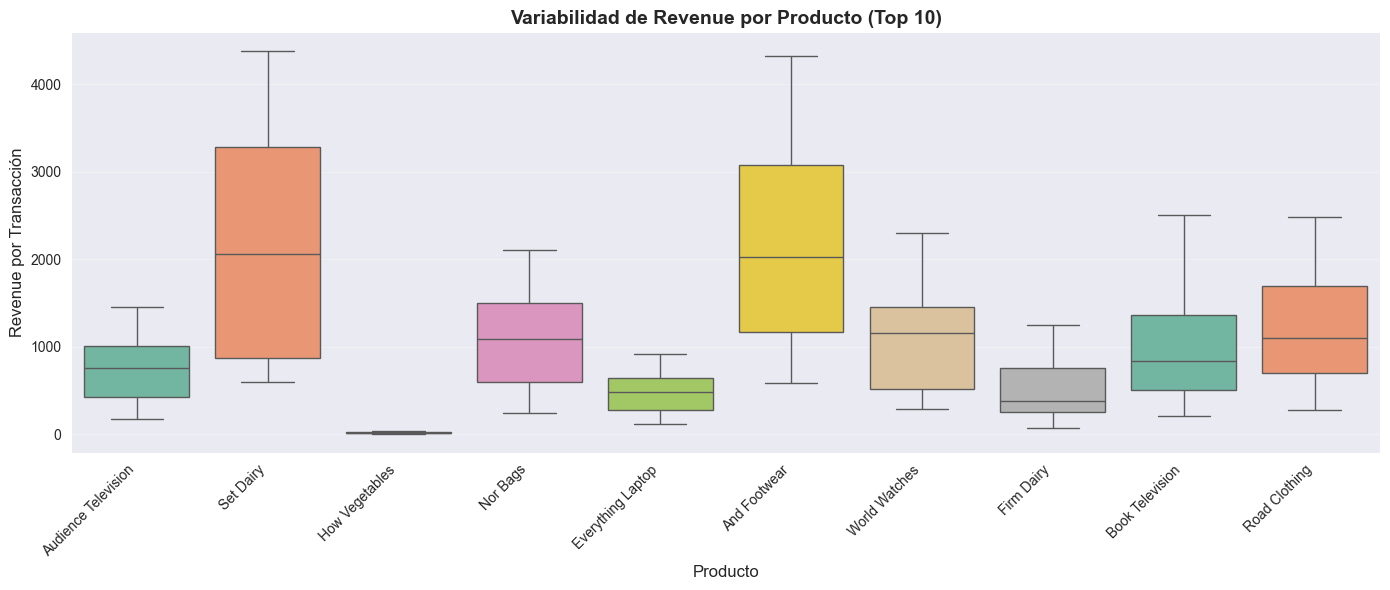

                     count         mean          std       min        25%  \
ProductName                                                                 
And Footwear         115.0  2126.984891  1105.025948  581.7895  1163.5790   
Audience Television  105.0   747.059981   366.539161  168.3260   418.5280   
Book Television      115.0  1008.266196   671.093397  208.4825   501.3800   
Everything Laptop    107.0   478.641472   229.437186  117.7725   278.3500   
Firm Dairy           107.0   493.222654   333.599961   66.0640   252.5010   
How Vegetables       107.0    15.882150     8.478584    2.6845     8.0535   
Nor Bags             104.0  1062.711615   562.290197  239.1060   599.8480   
Road Clothing        111.0  1240.014752   644.699961  273.9825   696.4700   
Set Dairy            111.0  2182.633135  1261.300184  592.6580   874.5200   
World Watches        115.0  1077.628696   563.825248  289.4800   519.3300   

                           50%       75%      max  
ProductName            

In [10]:
top_products = prod_rank.head(10).reset_index()['ProductID'].tolist()

df_top_products = df_merge_txp[df_merge_txp['ProductID'].isin(top_products)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_products, x='ProductName', y='Revenue', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Producto', fontsize=12)
plt.ylabel('Revenue por Transacción', fontsize=12)
plt.title('Variabilidad de Revenue por Producto (Top 10)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

stats = df_top_products.groupby('ProductName')['Revenue'].describe()
print(stats)


###### Según el gráfico de Pareto podemos concluir que 27 primeros productos generan el 80% de revenue (80/20)

#### Análisis por local

In [11]:
df_store = pd.read_csv('../data/Stores.csv')

In [12]:
store_rank = df_merge_txp.groupby(["StoreID"]).agg(
    unit_sold=("Quantity", "sum"),
    revenue=("Revenue", "sum"),
).sort_values("revenue", ascending=False)

In [13]:
df_merge_store = store_rank.merge(df_store[['StoreID','StoreName']], on='StoreID', how='left')
print(df_merge_store)

  StoreID  unit_sold      revenue                StoreName
0    S003       3036  804011.4700     MegaMart New Michele
1    S005       2886  772924.9530       MegaMart Johnmouth
2    S004       3018  769983.3480     MegaMart Brianahaven
3    S001       3061  753860.9260  MegaMart Jimenezborough
4    S002       2948  725533.9705       MegaMart Peckmouth


C:\Users\crist\AppData\Local\Temp\ipykernel_15512\310967264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_merge_store, x='StoreName', y='revenue', palette='Set2')


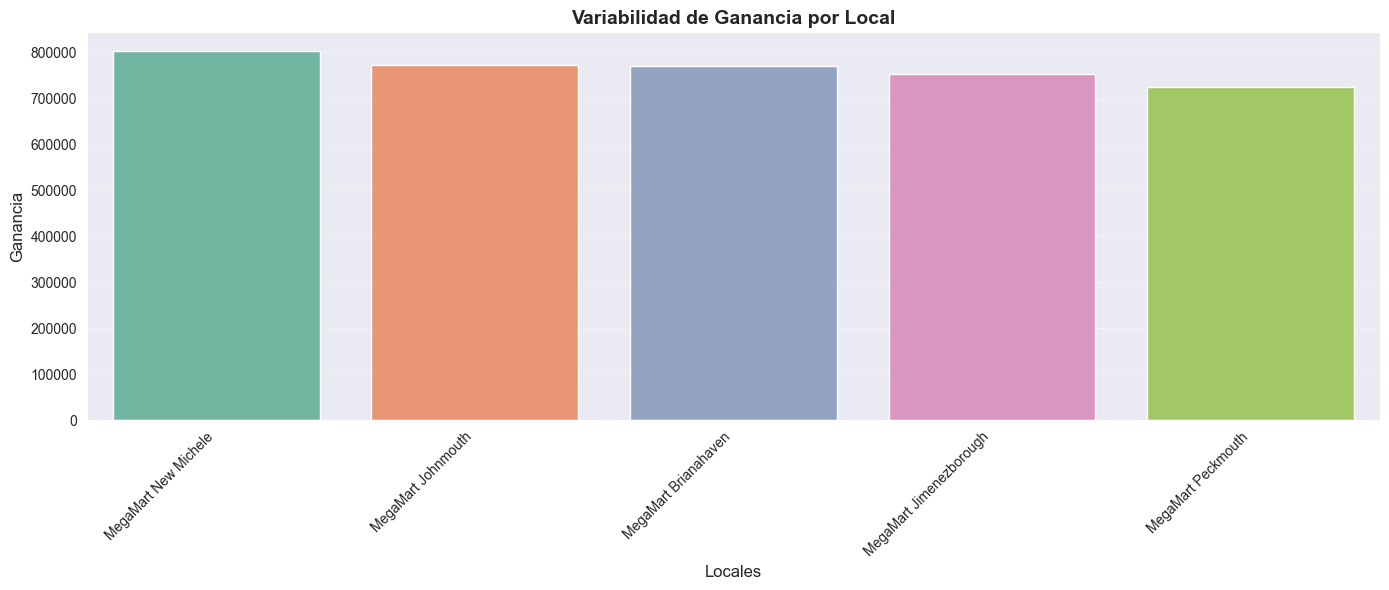

In [14]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_merge_store, x='StoreName', y='revenue', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Locales', fontsize=12)
plt.ylabel('Ganancia', fontsize=12)
plt.title('Variabilidad de Ganancia por Local', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Análisis cruzado top productos y tiendas

In [15]:
top_products = prod_rank.head(10).index.get_level_values("ProductID")
cross_df = df_merge_txp[df_merge_txp["ProductID"].isin(top_products)]
cross_table = cross_df.groupby(["StoreID", "ProductID"])["Revenue"].sum().unstack(fill_value=0)


In [16]:
print(cross_table)

ProductID       P002      P013       P021      P022        P023        P029  \
StoreID                                                                       
S001       12487.458  20437.48  12591.900  465.3425  39642.7230  23339.2625   
S002       11960.066  20574.08  14125.950  350.6670  56235.5290  24217.6050   
S003       18214.660  30365.44   7088.836  280.3565  62095.2830  27118.6225   
S004       17204.932  21788.74  10467.976  280.9940  35685.0495  36520.9675   
S005       18574.182  30761.56   8500.162  322.0300  50944.6780  26445.1800   

ProductID        P034        P037       P045       P048  
StoreID                                                  
S001       11529.6525  25505.1775  53700.080  29020.984  
S002       11412.2325  20799.6050  35934.970  16034.272  
S003        8082.5575  18828.6275  52406.506  15251.970  
S004        9624.2425  22364.7225  44976.662  30155.696  
S005       10565.9525  28452.4800  55254.060  20059.086  


##### Exportar a Csv

In [18]:
df_merge_txp.to_csv("../data/transaction_product.csv", index=False)
prod_rank.to_csv("../data/product_rank.csv", index=True)
store_rank.to_csv("../data/store_rank.csv", index=True)
cross_table.to_csv("../data/cross_table.csv", index=True)
print("Data exportados correctamente")

Data exportados correctamente
